# Translation Source Dialect Identification
## LightGBM submission

The approach: train one classifier for every language the text was translated to

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import spacy
import random
import fasttext
import nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing, metrics
from lightgbm import LGBMClassifier, plot_tree
from tqdm import tqdm
from IPython.display import FileLink, FileLinks

### Data load & preprocessing

In [2]:
train_df = pd.read_csv('../data/train_data.csv')
test_df = pd.read_csv('../data/test_data.csv')
train_df.head(10)

,language,text,label
0,dansk,"\nDette er et fremragende initiativ, og jeg st...",Ireland
1,dansk,"\nHr. formand, jeg er sikker på, at alle her e...",Ireland
2,dansk,"\nHr. formand, folk på den nordlige halvkugle ...",England
3,dansk,"\nHr. formand, med forbehold af nogle få ændri...",England
4,dansk,"\n\n - Hr. formand, jeg må protestere mod de...",England
5,dansk,"\nHr. formand, jeg ønsker det danske formandsk...",Ireland
6,dansk,\n\n De britiske konservative støtter holdni...,England
7,dansk,\nOppe i logen sidder der nogle gæster og lytt...,England
8,dansk,\nMedlemmerne af det britiske Konservative par...,England
9,dansk,"\nJeg støtter ordføreren, som foreslår, at Par...",Scotland


In [3]:
languages = list(set(train_df['language'].values))
print(languages)

['Deutsch', 'italiano', 'español', 'Nederlands', 'dansk']


In [4]:
train_df['text'].apply(lambda sentence: re.sub("[-.,;:!?\"\'\/()_*=`]", "", sentence).replace('\n', ' ').strip().lower())

0        dette er et fremragende initiativ og jeg støtt...
1        hr formand jeg er sikker på at alle her er kla...
2        hr formand folk på den nordlige halvkugle tror...
3        hr formand med forbehold af nogle få ændringer...
4        hr formand jeg må protestere mod den lemfældig...
                               ...                        
41565    mijnheer de voorzitter juridisch gezien is het...
41566    mijnheer de voorzitter het is niet mijn taak d...
41567    als afgevaardigde van ierland het voedseleilan...
41568    mijnheer de voorzitter het is niet onterecht d...
41569    stelt u zich voor dat een ander wetgevend lich...
Name: text, Length: 41570, dtype: object

In [5]:
def tokenize_text(text, language):
    tokens = []
    for sent in nltk.sent_tokenize(text, language=language):
        for word in nltk.word_tokenize(sent, language=language):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [6]:
le = preprocessing.LabelEncoder()
le.fit(['England', 'Scotland', 'Ireland'])

LabelEncoder()

In [7]:
langToEn = { 
    'español': 'spanish',
    'Nederlands': 'dutch',
    'italiano': 'italian',
    'dansk': 'danish',
    'Deutsch': 'german'
}

sentences = {language: [tokenize_text(text, langToEn[language]) for text in train_df[train_df['language']==language]['text'].values] for language in languages}

In [8]:
labels = {language: le.transform(train_df[train_df['language']==language]['label'].values) for language in languages}

### Model train & validation

In [9]:
def build_classifier(language, classifier):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform([" ".join(sentence) for sentence in sentences[language]]).astype(np.float64)
    y = labels[language]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2)
    classifier.fit(X_train, y_train)
    return y_val, classifier.predict(X_val), classifier

In [10]:
Y_true = []
Y_pred = []
models = {}
for language in languages:
    y_t, y_p, model = build_classifier(language,  LGBMClassifier(n_jobs=4, objective='multiclass', max_depth=0, n_estimators=200, min_child_samples=10, reg_alpha=0.5, reg_lambda=0.5))
    Y_true.extend(y_t)
    Y_pred.extend(y_p)
    models[language] = model

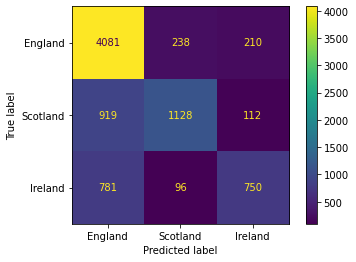

In [11]:
confusion_matrix = metrics.confusion_matrix(Y_true, Y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels =['England', 'Scotland', 'Ireland'])
cm_display.plot()
plt.show()

In [12]:
plot_tree(models['dansk'], figsize=(512,512))

<AxesSubplot:>

In [13]:
def range_with_floats(start, stop, step):
    while stop > start:
        yield start
        start += step

In [14]:
def build_vectorizers(language):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform([" ".join(sentence) for sentence in sentences[language]]).astype(np.float64)
    return X, vectorizer

In [15]:
def build_final_classifier(language, X, classifier):
    y = labels[language]
#     X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=seed)
    classifier.fit(X, y)
    return classifier

In [16]:
vectorizers = {language: build_vectorizers(language) for language in languages}

In [17]:
%%time
classifiers = {language:build_final_classifier(language, vectorizers[language][0], LGBMClassifier(n_jobs=4, objective='multiclass', max_depth=0, n_estimators=200, min_child_samples=10, reg_alpha=0.5, reg_lambda=0.5)) for language in tqdm(languages)}

100%|██████████| 5/5 [01:19<00:00, 15.97s/it]

CPU times: user 5min 1s, sys: 1.18 s, total: 5min 2s
Wall time: 1min 19s


### Preparing test data
The test data is passed through a language detection model, then split by identified language in such a way that it can then be reformed in the initial order for the final submission

In [18]:
test_df['text'].apply(lambda sentence: re.sub("[-.,;:!?\"\'\/()_*=`]", "", sentence).replace('\n', ' ').strip().lower())

0        hr formand selv om vi i høj grad sympatiserer ...
1        quiero dejar constancia de mi apoyo a este inf...
2        – el comercio ilegal de riñones humanos se ha ...
3        signor presidente per introdurre una nota di a...
4        jeg stemte for meddelelsen af decharge til fæl...
                               ...                        
13855    schriftlich  dieser bericht handelt von wichti...
13856    signor presidente desidero ringraziare il rela...
13857    en ich unterstütze den bericht von herrn dover...
13858    – mijnheer de voorzitter ik ben verheugd dat z...
13859    jeg stemte for at bekræfte hr trichet som form...
Name: text, Length: 13860, dtype: object

In [19]:
test_sentences = np.array([re.sub("[-.,;:!?\"\'\/()_*=`]", "", sentence).replace('\n', ' ').strip().lower() for sentence in test_df['text'].values], dtype=str)

In [20]:
!wget https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.ftz

--2023-03-23 13:22:16--  https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.ftz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.65.229.95, 18.65.229.89, 18.65.229.46, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.65.229.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 938013 (916K) [binary/octet-stream]
Saving to: ‘lid.176.ftz.5’

lid.176.ftz.5       100%[===================>] 916.03K  --.-KB/s    in 0.03s   

2023-03-23 13:22:16 (26.4 MB/s) - ‘lid.176.ftz.5’ saved [938013/938013]



In [21]:
model = fasttext.load_model('lid.176.ftz')
for sentence in test_sentences:
    lang = model.predict(sentence, k=1)[0][0]

In [22]:
label_to_lang = {
    '__label__nl': 'Nederlands',
    '__label__es': 'español',
    '__label__de': 'Deutsch',
    '__label__da': 'dansk',
    '__label__it': 'italiano',
    '__label__en': 'español'
}

In [23]:
test_df.insert(1, 'language', [label_to_lang[model.predict(sentence, k=1)[0][0]] for sentence in test_sentences], True)
test_df.head()

,text,language
0,"\n\n Hr. formand, selv om vi i høj grad symp...",dansk
1,\n\n Quiero dejar constancia de mi apoyo a e...,español
2,\n\n . – El comercio ilegal de riñones human...,español
3,"\nSignor Presidente, per introdurre una nota d...",italiano
4,\nJeg stemte for meddelelsen af decharge til f...,dansk


In [24]:
poz = np.argsort(test_df['language'].values)

In [25]:
test_sent_dict = { 
    'español': [],
    'Nederlands': [],
    'italiano': [],
    'dansk': [],
    'Deutsch': []
}
for i, sentence in enumerate(test_df['text'].values[poz]):
    test_sent_dict[test_df['language'].values[poz][i]].append(" ".join(tokenize_text(sentence, langToEn[test_df['language'].values[poz][i]])))

### Final predictions

In [26]:
def revert_argsort(arr, pozs):
    result = np.zeros(len(arr), dtype='object')
    for i in range(len(arr)):
        result[pozs[i]] = arr[i]
    return result

In [27]:
def reform():
    keys = list(test_sent_dict.keys())
    keys.sort()
    result = []
    for key in keys:
        result = np.concatenate((result, test_sent_dict[key]))
    return np.array(result)

In [28]:
for key in test_sent_dict.keys():
    X = vectorizers[key][1].transform(test_sent_dict[key])
    Y = classifiers[key].predict(X.astype(np.float64))
    test_sent_dict[key] = Y

In [29]:
np.array(revert_argsort(reform(), poz), dtype=int)

array([0, 1, 0, ..., 0, 0, 2])

In [30]:
pred_labels = le.inverse_transform(np.array(revert_argsort(reform(), poz), dtype=int))

In [31]:
pred_labels[:5]

array(['England', 'Ireland', 'England', 'England', 'Scotland'],
      dtype='<U8')

In [32]:
sub = pd.read_csv('../data/sample_submission.csv')
sub['label'] = np.array(pred_labels)
sub.to_csv('submission.csv', index=False)

In [33]:
FileLinks('.') #lists all downloadable files on server

./
  lid.176.ftz.4
  __notebook_source__.ipynb
  lid.176.ftz.5
  lid.176.ftz.3
  lid.176.ftz.2
  submission.csv
  lid.176.ftz.1
  state.db
  lid.176.ftz